<a href="https://colab.research.google.com/github/Brandonff13/IdentificacionModelos/blob/master/proofdmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se utiliza el siguiente modelo SEIR metapoblacional:
$$ \frac{dS_i(t)}{dt}=-S_i(t) \sum_{j=1}^{n} \beta_{ij} (I_j(t)+ ϵ E_j(t)), $$

$$ \frac{dE_i(t)}{dt}=S_i(t) \sum_{j=1}^{n} \beta_{ij} (I_j(t)+ ϵ E_j(t))-k_iE_i(t), $$

$$ \frac{dI_i(t)}{dt}=k_iE_i(t)-\gamma_iI_i(t), $$

$$ \frac{dR_i(t)}{dt}=\gamma_iI_i(t), $$
para $i=1,...,n$ donde
$$\beta_{ij}=\sum_{k=1}^n \frac{\beta^k p_{ik} p_{jk}}{w_k}\quad \text{y} \quad w_k=\sum_{j=1}^n p_{jk}N_j.$$
Con condiciones iniciales $S_i(0)=N_i$, $E_i(0)=0$, $I_i(0)=0$, $R_i(0)=0$ para $i=2,...,n$; y $S_1(0)=N_1-2$, $E_1(0)=1$, $I_1(0)=1$, $R_1(0)=0$.
Los parámetros epidemiológicos se muestran en la siguiente tabla:

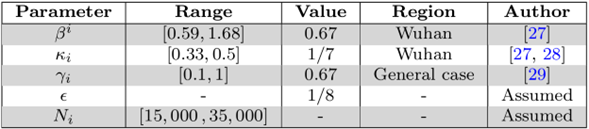

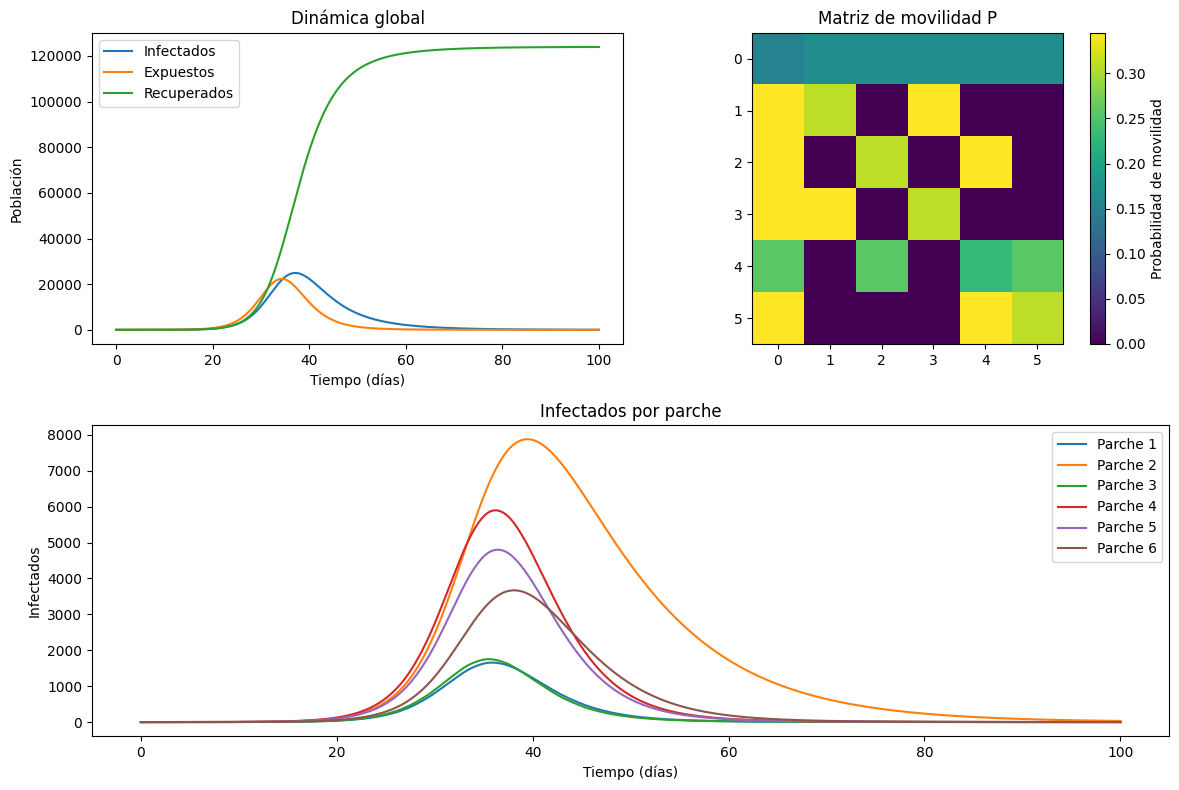

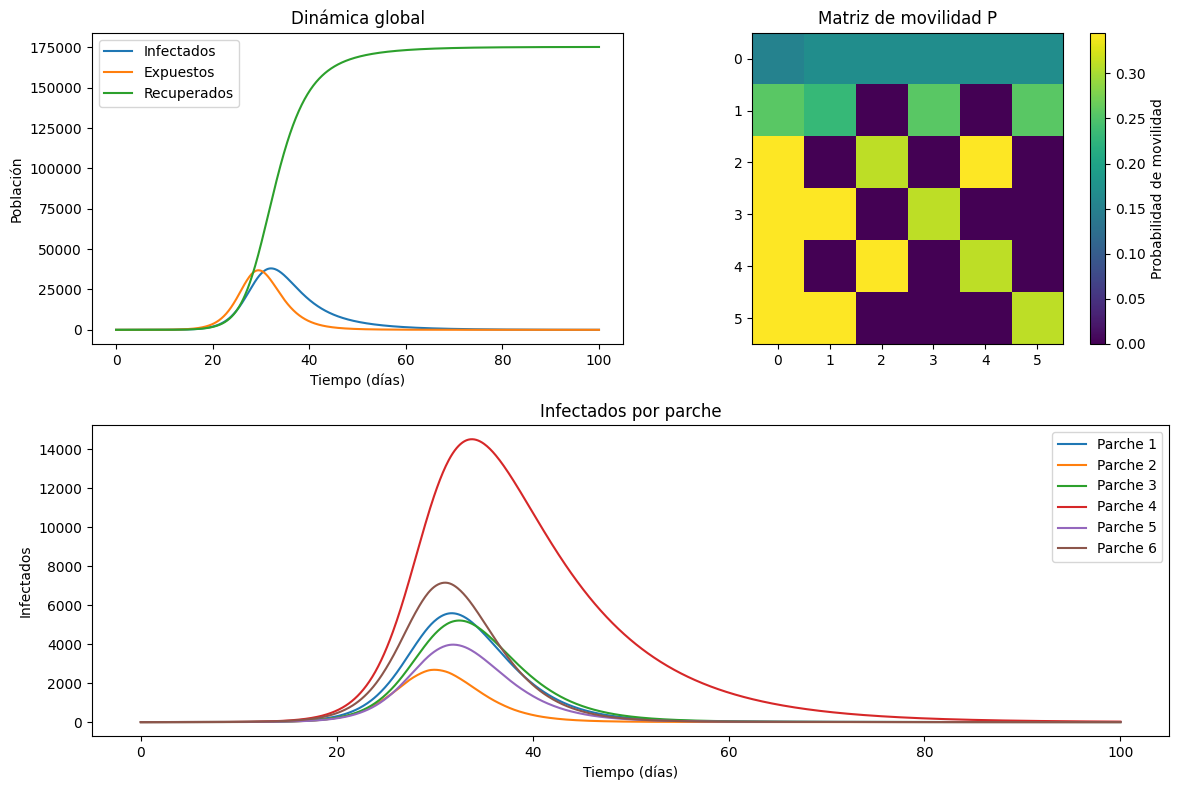

In [1]:
#Importación de librerias
import numpy as np
import networkx as nx
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parámetros epidemiológicos (Tabla 1)
params = {
    'beta_range': (0.59, 1.68),  # Rango para beta^i
    'kappa_range': (0.33, 0.5),   # 1/7 días^-1 (período incubación)
    'gamma_range': (0.1, 1.0),    # Tasa de recuperación
    'epsilon': 1/8,               # Factor de reducción infectividad expuestos
    'N_range': (15000, 35000),    # Rango poblaciones por parche
    'K': 0.3                      # Parámetro de eficiencia de control (no se usa aún)
}

#Genera la red de movilidad
def generar_red(n, tipo='BA'):
    """Genera red de movilidad Barabási-Albert o Erdős-Rényi"""
    if tipo == 'BA':
        G = nx.barabasi_albert_graph(n, m=2)
    else:
        G = nx.erdos_renyi_graph(n, p=0.5)
    P = nx.to_numpy_array(G).astype(float)
    #Normaliza para que un 90% de la población se quede en su respectivo parche
    for i in range(n):
        P[i, i] = 0.9
        P[i, :] /= P[i, :].sum()
    return P

"""
Inicialización de parches
 Asigna una población total aleatoria N[i] a cada parche.
 Condiciones iniciales: todos comienzan sanos, en el primer parche
 se introducen 2 casos iniciales 1 expuesto y 1 infectado.
 Parámetros epidemiológicos distintos para cada parche.
"""

def inicializar_parches(n):
    """Inicializa parámetros y condiciones iniciales"""
    N = np.random.randint(*params['N_range'], size=n)
    S0 = N.astype(float).copy()
    E0 = np.zeros(n)
    I0 = np.zeros(n)
    R0 = np.zeros(n)
    # Introducir caso inicial en parche 1
    S0[0] -= 2
    E0[0] = 1
    I0[0] = 1
    # Parámetros por parche
    beta = np.random.uniform(*params['beta_range'], size=n)
    kappa = np.random.uniform(*params['kappa_range'], size=n)
    gamma = np.random.uniform(*params['gamma_range'], size=n)
    return N, S0, E0, I0, R0, beta, kappa, gamma

"""
Calcula beta_{ij}, que determina la tasa de infección entre parches
"""
def construir_beta_mat(beta, P, N):
    """
    Construye la matriz beta_{ij} = sum_k beta^k p_{ik} p_{jk} / w_k
    donde w_k = sum_j p_{jk} N_j.
    """
    n = len(beta)
    w = P.T.dot(N)
    beta_mat = np.zeros((n, n))
    for k in range(n):
        beta_mat += beta[k] * np.outer(P[:, k], P[:, k]) / w[k]
    return beta_mat


def modelo_SEIR(t, y, n, beta_mat, kappa, gamma, epsilon):
    """Ecuaciones diferenciales del modelo SEIR en red"""
    # Divide el vector y en S,E,I,R.
    S, E, I, R = y[:n], y[n:2*n], y[2*n:3*n], y[3*n:]
    # Fuerza de infección: suma_j beta_ij (I_j + ε E_j)
    inf = beta_mat.dot(I + epsilon * E)
    dSdt = -S * inf
    dEdt = S * inf - kappa * E
    dIdt = kappa * E - gamma * I
    dRdt = gamma * I
    return np.concatenate([dSdt, dEdt, dIdt, dRdt])

"""
Genera la red de movilidad.
Inicializa las poblaciones y parametros.
Construye la matriz beta_{ij} de transmisión.
Integra el sistema SEIR usando solve_ivp.
Devuelve un diccionario con todos los resultados.
"""

def simular_red_SEIR(n=6, tipo_red='BA', t_max=100):
    """Simulación completa del modelo."""
    P = generar_red(n, tipo_red)
    N, S0, E0, I0, R0, beta, kappa, gamma = inicializar_parches(n)
    beta_mat = construir_beta_mat(beta, P, N)
    # Integrar SEIR
    y0 = np.concatenate([S0, E0, I0, R0])
    sol = solve_ivp(modelo_SEIR, (0, t_max), y0,
                    args=(n, beta_mat, kappa, gamma, params['epsilon']),
                    t_eval=np.linspace(0, t_max, 1000))
    S, E, I, R = sol.y[:n], sol.y[n:2*n], sol.y[2*n:3*n], sol.y[3*n:]
    return {'t': sol.t, 'S': S, 'E': E, 'I': I, 'R': R,
            'N': N, 'P': P}

"""
Genera tres gráficos:
Dinámica global (suma de expuestos, infectados y recuperados).
Infectados por parche (curvas individuales para cada región).
Matriz de movilidad P (mapa de calor con las probabilidades de desplazamiento).
"""

def visualizar_resultados(resultados):
    plt.figure(figsize=(12, 8))
    # Curvas agregadas
    plt.subplot(2, 2, 1)
    plt.plot(resultados['t'], resultados['I'].sum(axis=0), label='Infectados')
    plt.plot(resultados['t'], resultados['E'].sum(axis=0), label='Expuestos')
    plt.plot(resultados['t'], resultados['R'].sum(axis=0), label='Recuperados')
    plt.title('Dinámica global')
    plt.xlabel('Tiempo (días)')
    plt.ylabel('Población')
    plt.legend()
    # Infectados por parche
    plt.subplot(2, 2, (3, 4))
    for i in range(len(resultados['N'])):
        plt.plot(resultados['t'], resultados['I'][i], label=f'Parche {i+1}')
    plt.title('Infectados por parche')
    plt.xlabel('Tiempo (días)')
    plt.ylabel('Infectados')
    plt.legend()
    # Matriz de movilidad
    plt.subplot(2, 2, 2)
    plt.imshow(resultados['P'], cmap='viridis')
    plt.colorbar(label='Probabilidad de movilidad')
    plt.title('Matriz de movilidad P')
    plt.tight_layout()
    #plt.savefig('resultados_red.png')
    plt.show()

 #Ejecución de ejemplo
if __name__ == '__main__':
    for tipo in ['BA', 'ER']:
        res = simular_red_SEIR(6, tipo)
        visualizar_resultados(res)

El algoritmo DMD busca la descomposición espectral principal (es decir, valores propios y vectores propios) del operador lineal $A$ de mejor ajuste que relaciona las dos matrices de snapshot en el tiempo:
$$X' \approx AX,$$
donde $X=[x_1 \quad x_2 \quad \dots \quad x_m]$ y $X'=[x_2 \quad x_3 \quad \dots \quad x_{m+1}]$.

Matemáticamente, el operador de mejor ajuste $A$ se define como:
$$A = \arg \min_A ||X'-AX||_{F}=X'X^+$$

Descomposición Ortogonal Propia: $X=U\Sigma V^t \longrightarrow X^+=V\Sigma^{-1}U^t$.

Aproximación: $\tilde{A}=U^t A U =U^tX'V\Sigma^t$.

Valores y vectores propios: $\tilde{A}W=W\Lambda$, $\Lambda$ es la matriz que tiene en la diagonal los $r$ valores propios.

Volver a coordenadas físicas: $\Phi=X'V\Sigma^{-1}W$($A\Phi=\Phi\Lambda$).

Calcular amplitud: $b=\Phi^+x_0.$

Predicción: $x_k=\Phi diag(b)\Lambda^k=\sum_{j=1}^r \phi_j b_j \lambda_j^k.$

In [10]:
"""
Se aplica Dynamic Mode Decomposition (DMD) al modelo SEIR en red
para ajustar la dinámica observada a un modelo de baja dimensión
que captura los modos dominantes del sistema.
"""

def aplicar_DMD_ajuste(resultados, r=10):
    """
    Aplica DMD a la matriz de estados SEIR (4n x T).
    """
    #Construcción de la matriz de estados
    X = np.vstack([resultados['S'], resultados['E'], resultados['I'], resultados['R']])
    X1 = X[:, :-1]
    X2 = X[:, 1:]

    # SVD
    U, Sigma, VT = np.linalg.svd(X1, full_matrices=False)
    # Tomamos los r modos dominantes
    Ur = U[:, :r]
    Sigmar = np.diag(Sigma[:r])
    Vr = VT[:r, :]

    # Atilde reducido
    # Add a small epsilon to the diagonal of Sigmar to avoid singular matrix
    epsilon = 1e-10  # Small value to add to the diagonal
    A_tilde = Ur.T @ X2 @ Vr.T @ np.linalg.inv(Sigmar + epsilon * np.eye(r))
    # Autovalores, modos y reconstrucción
    eigvals, W = np.linalg.eig(A_tilde)
    Phi = X2 @ Vr.T @ np.linalg.inv(Sigmar + epsilon * np.eye(r)) @ W
    """
    Se calculan los autovalores de Atilde que determinan las
    tasas de crecimiento y frecuencias.
    W son los autovectores en el espacio reducido.
    Phi son los modos dinamicos DMD en el espacio completo, cada columna
    es un modo espacial del sistema.
    """

    # Coeficientes iniciales
    x0 = X[:, 0]
    b = np.linalg.lstsq(Phi, x0, rcond=None)[0]

    # Reconstrucción (sin predicción futura)
    # Dinámica temporal en el espacio reducido
    T = X.shape[1]
    time_dynamics = np.zeros((r, T), dtype=complex)
    for i in range(T):
        time_dynamics[:, i] = b * (eigvals ** i)
    # Reconstrucción final
    X_dmd = Phi @ time_dynamics

    return X, X_dmd.real, resultados['t'], Phi

In [3]:
"""
Compara la reconstrucción obtenida con DMD contra los datos
simulados originales del modelo SEIR para los infectados totales.
"""

def visualizar_ajuste_DMD(X_real, X_dmd, t, n):
    """
    Entrada:
    Matriz de estados reales simulados
    Matriz de estados reconstruidos con DMD
    Tiempo
    Número de parches

    Salida:
    Muestra un grafico comparativo entre los datos reales y los
    reconstruidos con DMD.
    """
    # Selección de infectados reales y reconstruidos
    I_real = X_real[2 * n:3 * n, :]
    I_dmd = X_dmd[2 * n:3 * n, :]

    plt.figure(figsize=(10, 5))
    plt.plot(t, I_real.sum(axis=0), label='Simulación real')
    plt.plot(t, I_dmd.sum(axis=0), '--', label='DMD (ajuste)')
    plt.xlabel('Tiempo')
    plt.ylabel('Infectados totales')
    plt.title('Reconstrucción DMD vs Simulación real')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
def visualizar_ajuste_DMD_por_parche(X_real, X_dmd, t, n, variable='I'):
    """
    Compara la reconstrucción DMD con los datos reales para cada parche
    en la variable seleccionada: 'S', 'E', 'I' o 'R'.
    """

    """
    Entradas:
    Matriz de estados reales simulados
    Matriz de estados reconstruidos con DMD
    Tiempo
    Número de parches
    Variable a comparar: 'S', 'E', 'I' o 'R'
    Salida:
    Muestra un grafico comparativo entre los datos reales y los
    reconstruidos con DMD para la variable seleccionada.
    """

    # Determinar índices según variable
    var_indices = {'S': (0, n), 'E': (n, 2*n), 'I': (2*n, 3*n), 'R': (3*n, 4*n)}
    start, end = var_indices[variable]

    V_real = X_real[start:end, :]
    V_dmd = X_dmd[start:end, :]

    plt.figure(figsize=(12, 8))
    for i in range(n):
        plt.plot(t, V_real[i], label=f'{variable}_real parche {i+1}')
        plt.plot(t, V_dmd[i], '--', label=f'{variable}_DMD parche {i+1}')

    plt.title(f'Reconstrucción DMD vs Real para variable {variable}')
    plt.xlabel('Tiempo')
    plt.ylabel(f'{variable}(t)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
import seaborn as sns

def visualizar_modos_DMD(Phi, n, r, variable_order=['S','E','I','R']):
    """
    Genera un mapa de calor de la magnitud de los modos DMD.

    Parámetros:
    -----------
    Phi : matriz (4n x r)
        Matriz de modos DMD (columnas = modos, filas = variables/parches).
    n : int
        Número de parches.
    r : int
        Número de modos considerados.
    variable_order : list
        Orden de variables ['S','E','I','R'].
    """
    # Creamos etiquetas para filas: S1,...,Sn,E1,...,En,I1,...,In,R1,...,Rn
    etiquetas = []
    for var in variable_order:
        for i in range(1, n+1):
            etiquetas.append(f"{var}{i}")

    # Tomamos magnitudes absolutas de los modos
    Phi_abs = np.abs(Phi[:, :r])

    plt.figure(figsize=(12, 8))
    sns.heatmap(Phi_abs, cmap="viridis", xticklabels=[f"Modo {j+1}" for j in range(r)],
                yticklabels=etiquetas, cbar_kws={'label': 'Magnitud |Φ|'})
    plt.title("Mapa de calor: contribución de variables/parches a los modos DMD")
    plt.xlabel("Modos DMD")
    plt.ylabel("Variables SEIR por parche")
    plt.tight_layout()
    plt.show()


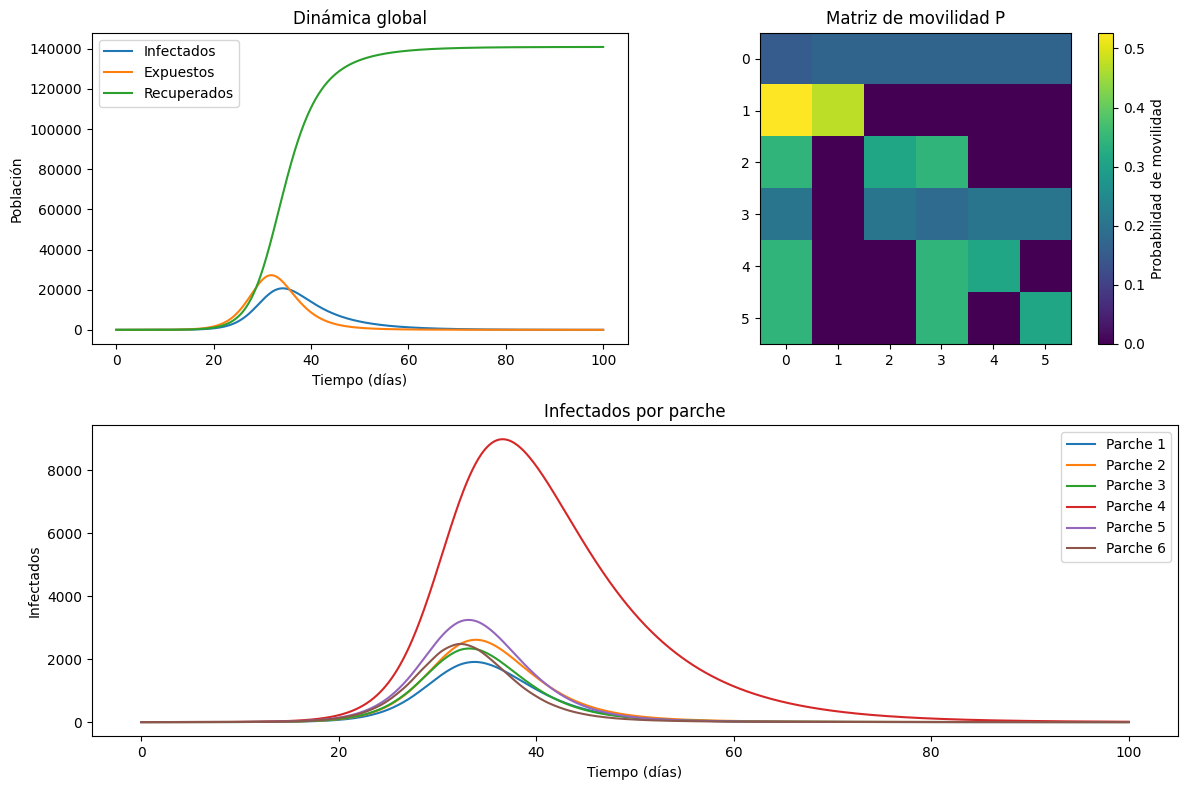

Ajustando DMD a los datos reales para red tipo BA


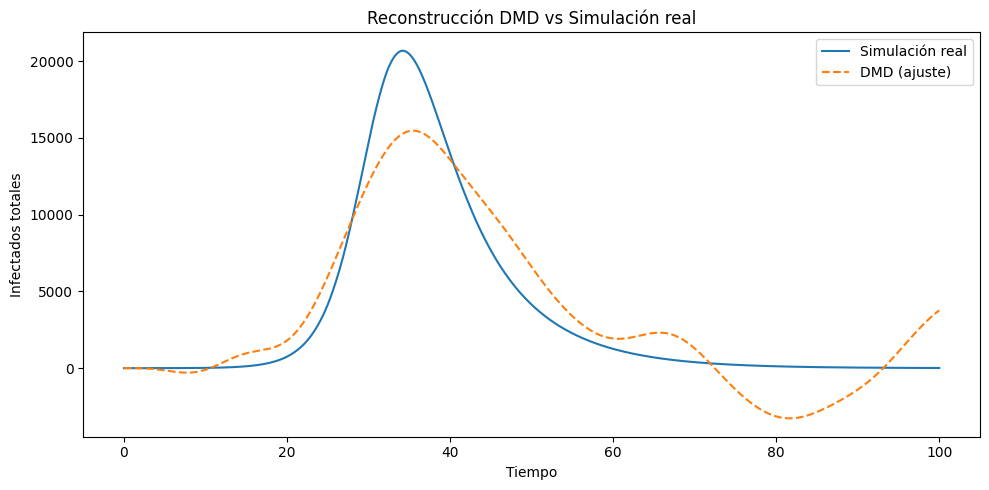

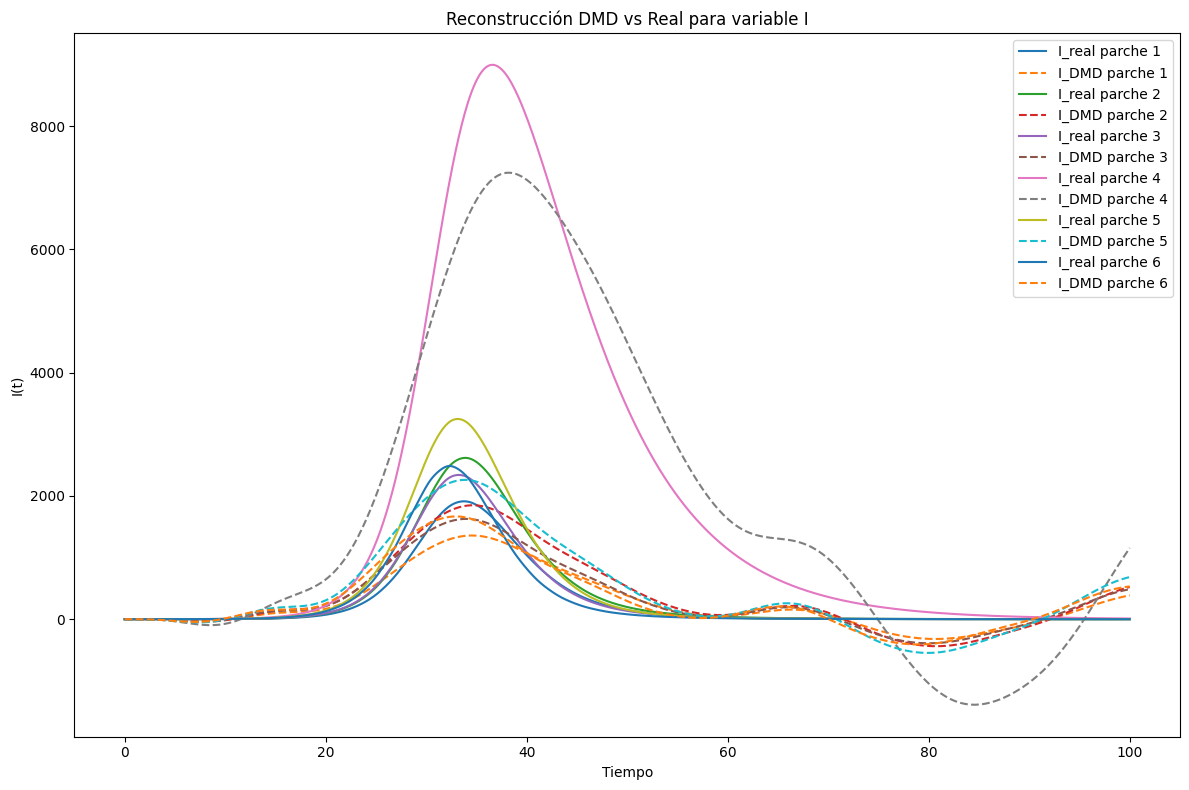

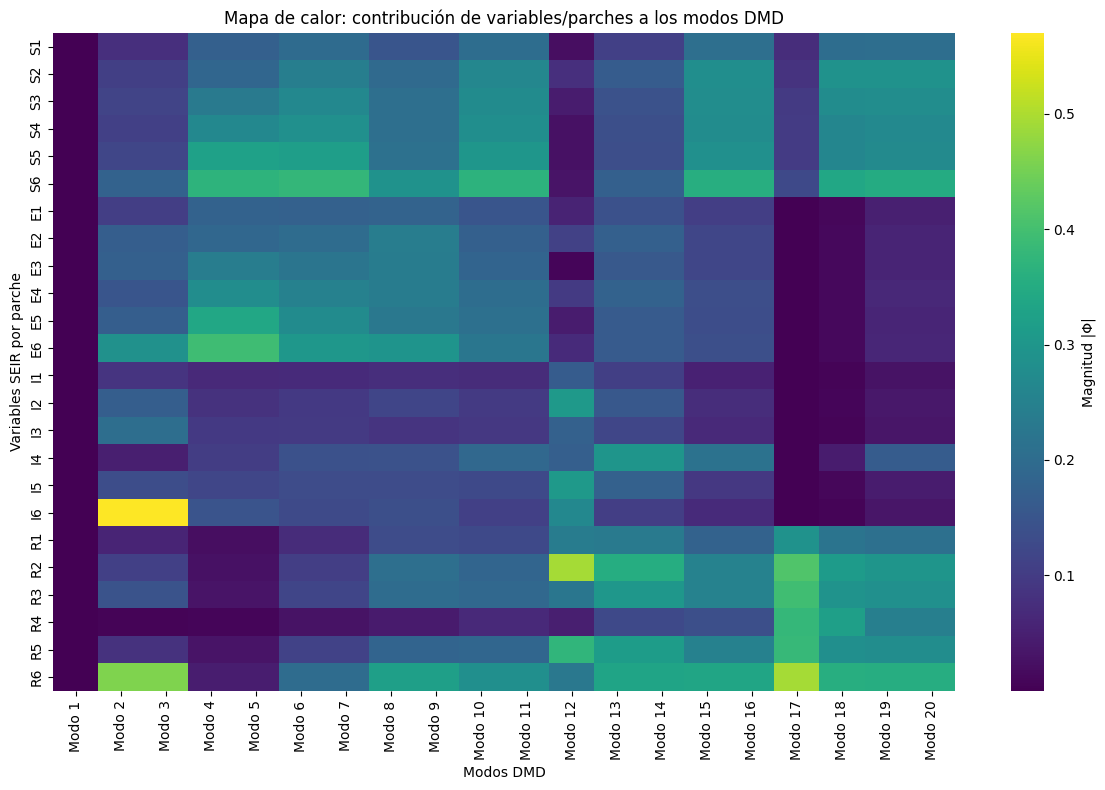

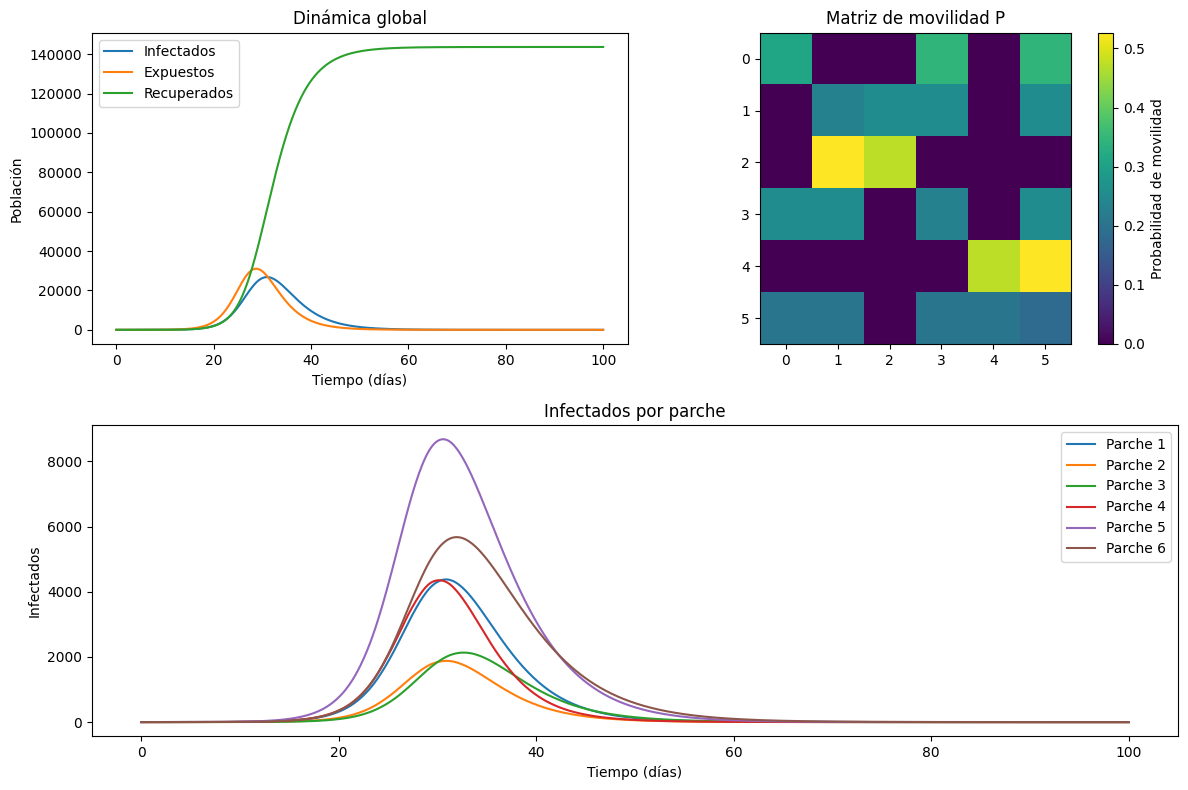

Ajustando DMD a los datos reales para red tipo ER


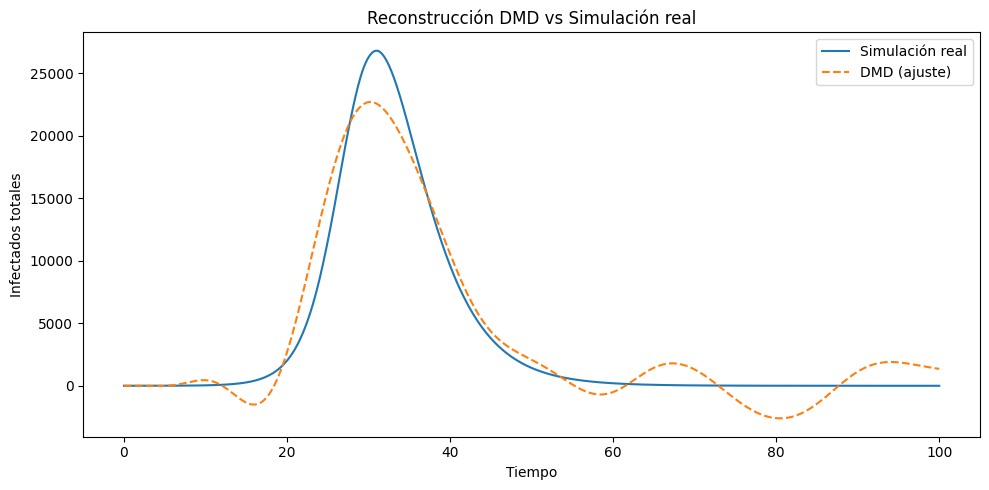

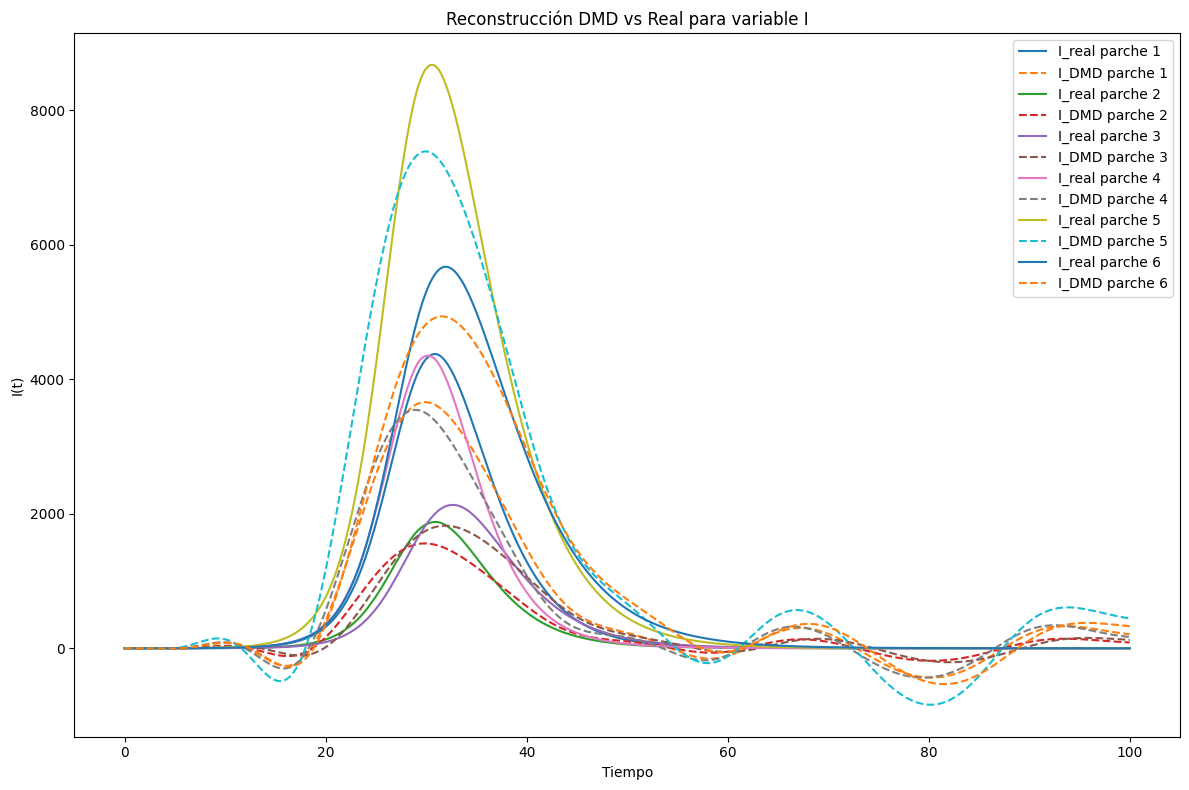

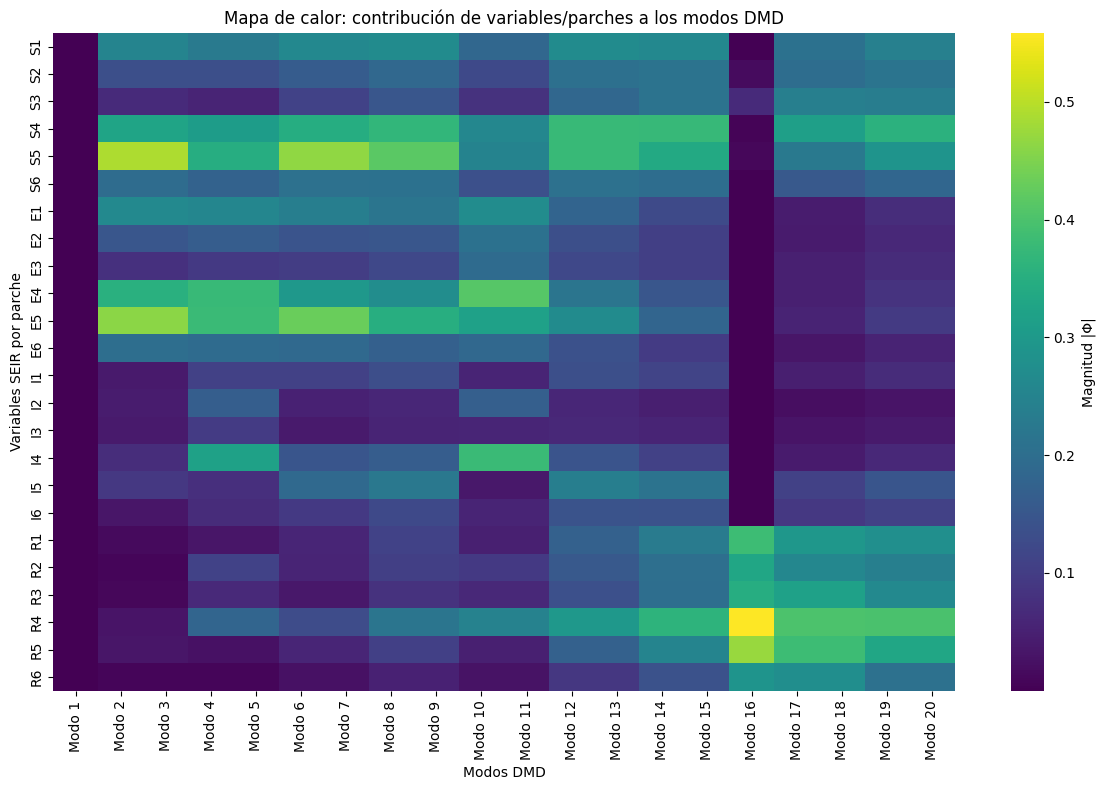

In [6]:
if __name__ == '__main__':
    #Se simulan los dos tipos de redes
    for tipo in ['BA', 'ER']:
        res = simular_red_SEIR(6, tipo)
        visualizar_resultados(res)

        print(f"Ajustando DMD a los datos reales para red tipo {tipo}")
        X_real, X_dmd, t, Phi = aplicar_DMD_ajuste(res, r=20) # Se toman los r modos más significativos (en este caso r=20)
        visualizar_ajuste_DMD(X_real, X_dmd, t, n=6)
        # Validar por parche para infectados
        visualizar_ajuste_DMD_por_parche(X_real, X_dmd, t, n=6, variable='I')
        visualizar_modos_DMD(Phi, n=6, r=20)

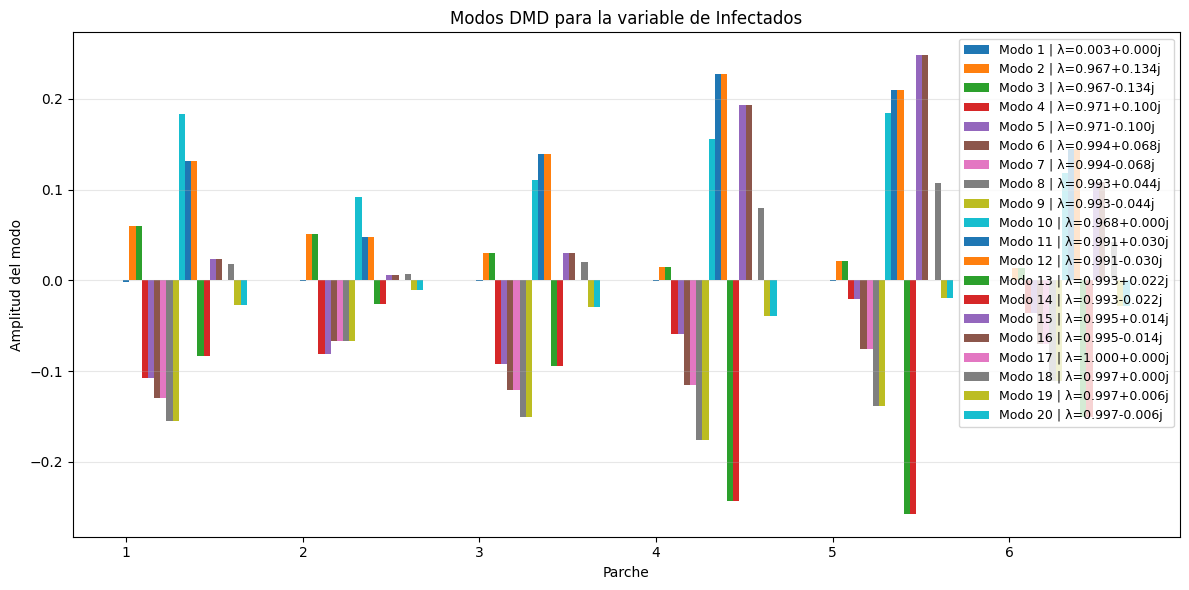

In [8]:

# Re-run simulation and DMD to ensure variables are available
res = simular_red_SEIR(6, 'BA') # You can change 'BA' to 'ER' or loop through both if needed
X_real, X_dmd, t, Phi = aplicar_DMD_ajuste(res, r=20) # Use the desired value for r

# Extract DMD modes and eigenvalues
X1 = np.vstack([res['S'], res['E'], res['I'], res['R']])[:, :-1]
X2 = np.vstack([res['S'], res['E'], res['I'], res['R']])[:, 1:]
U, Sigma, VT = np.linalg.svd(X1, full_matrices=False)
r = 20  # Make sure this matches the r used in aplicar_DMD_ajuste
Ur = U[:, :r]
Sigmar = np.diag(Sigma[:r])
Vr = VT[:r, :]
A_tilde = Ur.T @ X2 @ Vr.T @ np.linalg.inv(Sigmar)
eigvals, W = np.linalg.eig(A_tilde)
Phi = X2 @ Vr.T @ np.linalg.inv(Sigmar) @ W

n = res['I'].shape[0]
modos_infectados = Phi[2*n:3*n, :]  # Solo las filas correspondientes a I

plt.figure(figsize=(12, 6))
width = 0.7 / r  # ancho de barras relativo para evitar superposición

    # Para cada modo DMD
for i in range(r):
        plt.bar(
            np.arange(1, n + 1) + i * width,
            modos_infectados[:, i].real,
            width=width,
            label=f'Modo {i+1} | λ={eigvals[i]:.3f}'
        )

plt.title("Modos DMD para la variable de Infectados")
plt.xlabel("Parche")
plt.ylabel("Amplitud del modo")
plt.xticks(np.arange(1, n + 1))
plt.legend(fontsize=9)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

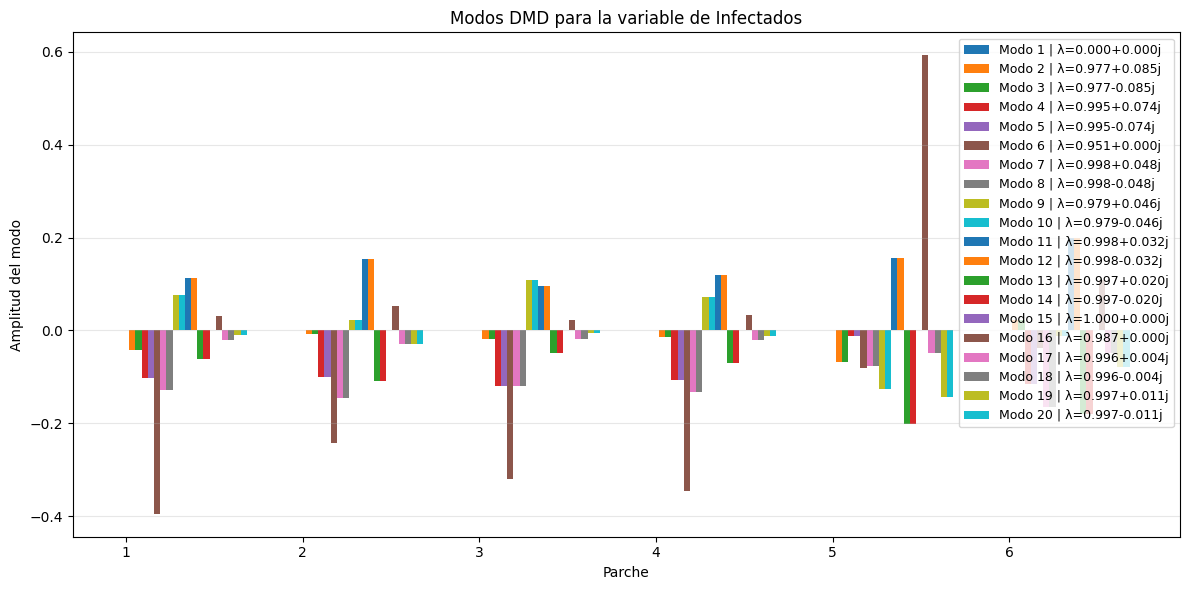

In [11]:

# Re-run simulation and DMD to ensure variables are available
res = simular_red_SEIR(6, 'ER') # You can change 'BA' to 'ER' or loop through both if needed
X_real, X_dmd, t, Phi = aplicar_DMD_ajuste(res, r=20) # Use the desired value for r

# Extract DMD modes and eigenvalues
X1 = np.vstack([res['S'], res['E'], res['I'], res['R']])[:, :-1]
X2 = np.vstack([res['S'], res['E'], res['I'], res['R']])[:, 1:]
U, Sigma, VT = np.linalg.svd(X1, full_matrices=False)
r = 20  # Make sure this matches the r used in aplicar_DMD_ajuste
Ur = U[:, :r]
Sigmar = np.diag(Sigma[:r])
Vr = VT[:r, :]
A_tilde = Ur.T @ X2 @ Vr.T @ np.linalg.inv(Sigmar)
eigvals, W = np.linalg.eig(A_tilde)
Phi = X2 @ Vr.T @ np.linalg.inv(Sigmar) @ W

n = res['I'].shape[0]
modos_infectados = Phi[2*n:3*n, :]  # Solo las filas correspondientes a I

plt.figure(figsize=(12, 6))
width = 0.7 / r  # ancho de barras relativo para evitar superposición

    # Para cada modo DMD
for i in range(r):
        plt.bar(
            np.arange(1, n + 1) + i * width,
            modos_infectados[:, i].real,
            width=width,
            label=f'Modo {i+1} | λ={eigvals[i]:.3f}'
        )

plt.title("Modos DMD para la variable de Infectados")
plt.xlabel("Parche")
plt.ylabel("Amplitud del modo")
plt.xticks(np.arange(1, n + 1))
plt.legend(fontsize=9)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

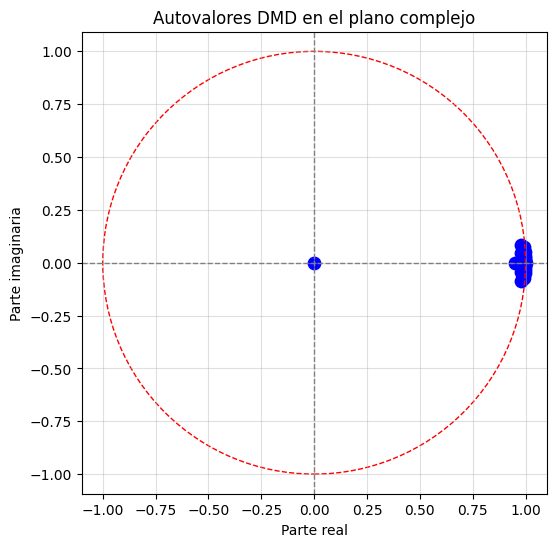

In [12]:
def graficar_autovalores(eigvals):
    plt.figure(figsize=(6, 6))
    plt.scatter(eigvals.real, eigvals.imag, color='blue', marker='o', s=80)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle="--")
    plt.gca().add_patch(circle)
    plt.title("Autovalores DMD en el plano complejo")
    plt.xlabel("Parte real")
    plt.ylabel("Parte imaginaria")
    plt.grid(alpha=0.4)
    plt.axis("equal")
    plt.show()
graficar_autovalores(eigvals)


In [13]:
#intentar el edmd
#graficar los primeros 9 nodos e interpretar
#grafica de barras de autovectores con etiqueta de eigenvalor
#analizar las estrategias e implementar en codigo